# Merging all folds test prediction

In [22]:
from collections import Counter
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
df1 = pd.read_csv("submissions/submission_fold_0.csv", dtype=str).rename(columns={"label": "label1"})
df2 = pd.read_csv("submissions/submission_fold_1.csv", dtype=str).rename(columns={"label": "label2"})
df3 = pd.read_csv("submissions/submission_fold_2.csv", dtype=str).rename(columns={"label": "label3"})
df4 = pd.read_csv("submissions/submission_fold_3.csv", dtype=str).rename(columns={"label": "label4"})
df5 = pd.read_csv("submissions/submission_fold_4.csv", dtype=str).rename(columns={"label": "label5"})

In [3]:
df1 = df1.merge(df2)
df1 = df1.merge(df3)
df1 = df1.merge(df4)
df1 = df1.merge(df5)

In [4]:
df1.shape

(1000, 6)

## Majority Voting
All cases where atleast 3 or more models make same prediction

In [5]:
label_cols = ["label1", "label2", "label3", "label4", "label5"]

In [6]:
df1["num_matches"] = df1[label_cols].apply(lambda x: Counter(x.values).most_common()[0][1], axis=1)
df1["most_frequent"] = df1[label_cols].mode(axis=1)[0]

In [7]:
df1["num_matches"].value_counts()

5    778
4    130
3     73
2     18
1      1
Name: num_matches, dtype: int64

In [8]:
df1.loc[df1["num_matches"]>=3]["most_frequent"].str.len().value_counts()

8    981
Name: most_frequent, dtype: int64

In [9]:
part1 = df1.loc[df1["num_matches"]>=3]

In [10]:
part2 = df1.loc[df1["num_matches"]<3]

## Character wise majority voting

In [11]:
def get_pred(values):
    pred = ""
    # ignore cases where prediction isn't of length 8
    values = [val for val in values if len(val)==8]
    try:
        for idx in range(8):
            pred += Counter([val[idx] for val in values]).most_common(1)[0][0]
    except Exception:
        pass
    return pred 

In [12]:
part2["most_frequent_after"] = part2[label_cols].apply(lambda x: get_pred(x.values.tolist()), axis=1)

### Combining both parts

In [13]:
part2["most_frequent"] = part2["most_frequent_after"]

In [14]:
df = part1[["tag", "most_frequent"]].append(part2[["tag", "most_frequent"]])

In [15]:
df = df.rename(columns={"most_frequent": "label"})

In [16]:
df["label"].str.len().value_counts()

8    1000
Name: label, dtype: int64

In [17]:
df.to_csv("submission.csv", index=False)

In [18]:
df.head()

,tag,label
0,0,79085871
1,1,71340881
2,2,79182781
3,3,47274881
4,4,85372881


### Plotting few Samples

Download the test dataset from here - https://www.kaggle.com/aditya08/arya-date?select=test

In [20]:
images = df["tag"].apply(lambda x: f"test/{x}.png")
labels = df["label"].tolist()

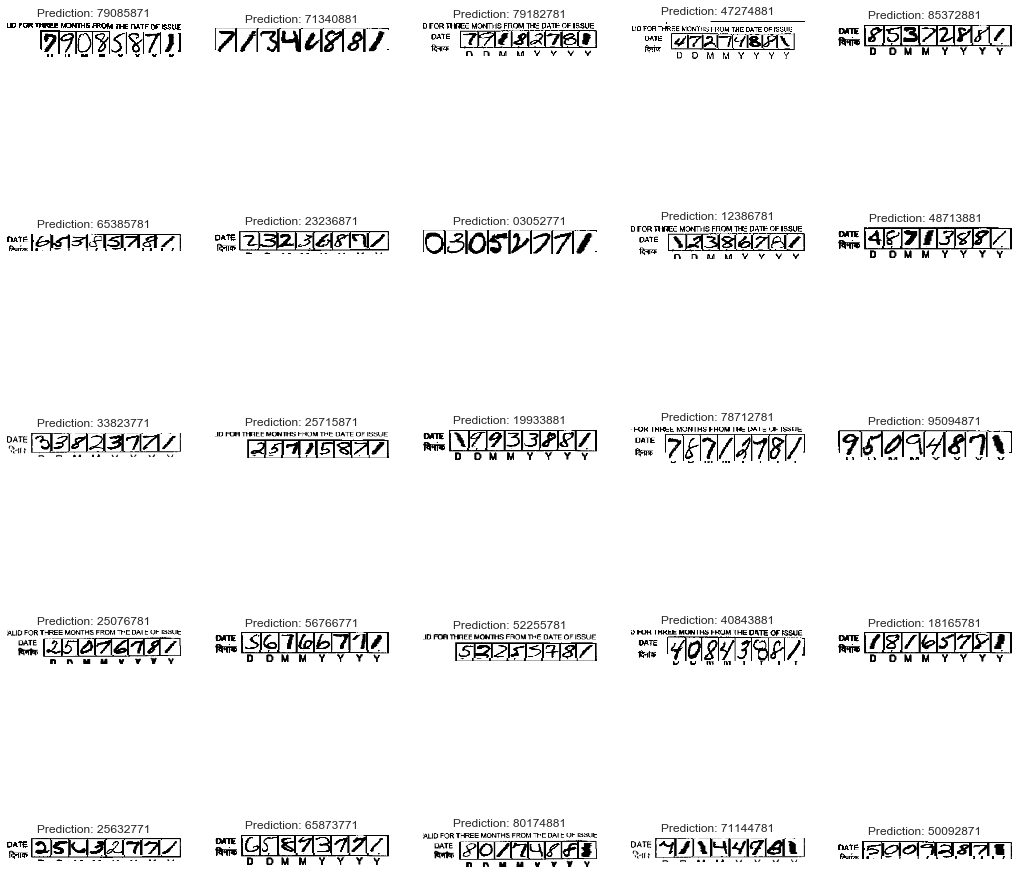

<Figure size 432x288 with 0 Axes>

In [25]:
h, w = 5, 5
_, ax = plt.subplots(h, w, figsize=(18, 18))
for i in range(h*w):
    img = Image.open(images[i])
    title = f"Prediction: {labels[i]}"
    ax[i // h, i % w].imshow(img, cmap="gray")
    ax[i // h, i % w].set_title(title)
    ax[i // h, i % w].axis("off")
plt.show()

### Submission

In [26]:
import requests
from pprint import pprint

In [27]:
PUBLIC_host = "http://13.232.114.193"
SUBMISSION_URL = PUBLIC_host + ":8080/submit"
LEADERBOARD_URL = PUBLIC_host + ":8080/leaderboard"

In [28]:
sub_json = df.to_json()
data = {
    "username": "aditya",
    "password": "xxxxx",
    "submission": sub_json,
    "tag": "deeper_model_kfold_trial",
}

In [29]:
r = requests.post(SUBMISSION_URL, json=data)
r.text

'{"success":true,"score":{"acc_8":0.955,"acc_7":0.961,"acc_5":0.969}}'

In [30]:
rl = requests.post(LEADERBOARD_URL, json={})
leaderboard = pd.DataFrame(rl.json()["leaderboard"])
leaderboard = leaderboard.sort_values(by=["score_8", "score_7", "score_5"], ascending=False)
leaderboard["submitted_at"] = leaderboard["submitted_at"].apply(lambda x: pd.to_datetime("-".join(x.split("-")[:-2])))

In [31]:
leaderboard.head(10)

,score_5,score_7,score_8,submitted_at,tag,username
0,0.969,0.961,0.955,2020-12-04 17:00:00,deeper_model_kfold,aditya
1,0.969,0.961,0.955,2020-12-04 19:00:00,deeper_model_kfold_trial,aditya
2,0.961,0.910,0.782,2020-12-04 18:00:00,deeper_crnn_v1,aditya
3,0.911,0.884,0.742,2020-11-10 12:00:00,crnn_v1_orig_test6,raj
4,0.918,0.862,0.723,2020-11-07 06:00:00,crnn_v1_orig_test2,raj
5,0.912,0.868,0.720,2020-11-07 08:00:00,crnn_v1_orig_test3,raj
6,0.912,0.868,0.720,2020-11-07 09:00:00,crnn_v1_orig_test4,raj
7,0.946,0.778,0.698,2020-11-07 07:00:00,digits_multi_v2,aditya
8,0.901,0.856,0.696,2020-11-06 14:00:00,crnn_v1_box,raj
9,0.936,0.780,0.692,2020-11-06 21:00:00,digits_multi_v1,aditya
